# Neural Collapse and Data Distillatioin

This notebook implements a visualization page for the data distillation algorithm utilizing the neural collapse. 

The main papers considered here are 
 - data distillation:
     - https://github.com/SsnL/dataset-distillation 
     - https://github.com/google-research/google-research/tree/master/kip
 - Neural Collapse:
     - https://github.com/tding1/Neural-Collapse. 

The neural network has fixed the last layer weight matrix to be a simplex ETF. The ETF is a benign optimization landscape empeirically observed in practice as long as the network enters its terminal phase.

Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [14]:
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy.linalg as scilin

import matplotlib.pyplot as plt
import time


import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchsummary import summary

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [2]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from train_Encoder import train
from validate_NC import *

from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W,compute_info,FCFeatures
from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *

# Load Parameters

In [3]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=True

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-Adam-SOTA"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'CrossEntropy'
sample_size = None

# optimization
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: mps, Apple Silicon GPU


In [5]:
args = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

override this uidResnet18-design-Adam-SOTA
cudnn is used


# Load Dataset

In [6]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class in our training set is ", num_classes)
print("Batch size: %d | Input size: %s" % (size_train,input_size))

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class in our training set is  10
Batch size: 64 | Input size: (32, 32, 3)


In [9]:
from Visualization import imshow
from Visualization import visualize_one_image_per_class
# # Check if trainloader is loaded
# if trainloader is None:
#     raise ValueError("Trainloader is not loaded. Please load it before running this script.")

# dataiter = iter(trainloader)
# imgs, lbls = next(dataiter)
# for i in range(100):  # show just the frogs
#     if lbls[i] == 1:  # 6 = frog
#         imshow(tv.utils.make_grid(imgs[i]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

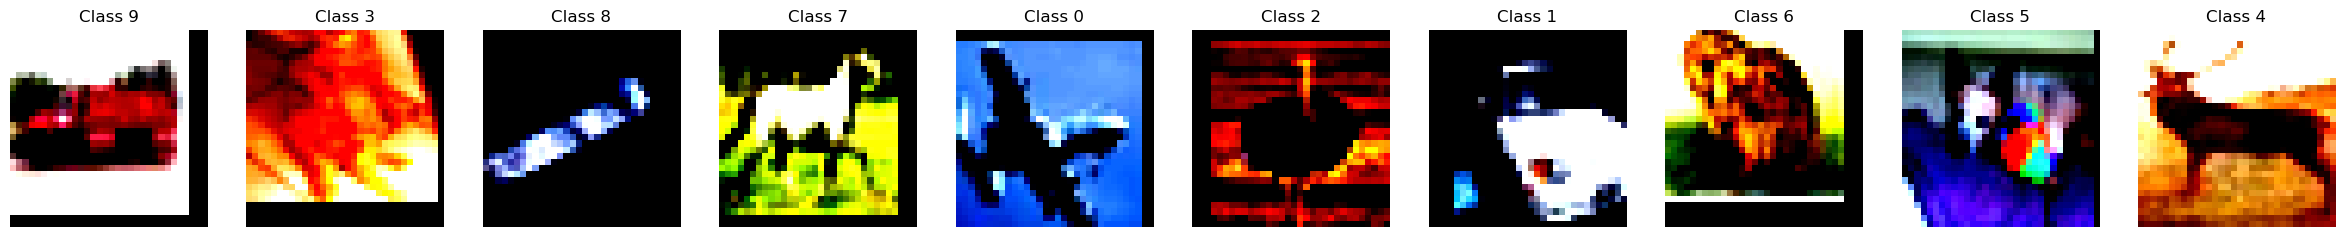

In [10]:
visualize_one_image_per_class(trainloader)

In [11]:
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
nc = channels
input_size = height, width
print("The number of class in our training set is ", num_classes)
print("Batch size:", size_train, 
      ", Number of channels:", channels, 
      ", input height:", height, 
      ", input width:", width)

The number of class in our training set is  10
Batch size: 64 , Number of channels: 3 , input height: 32 , input width: 32


# Load Model

In [12]:
if args.model == "MLP":
    Encoder = models.__dict__[args.model](hidden = args.width, depth = args.depth, fc_bias=args.bias, num_classes=num_classes).to(args.device)
elif args.model == "ResNet18_adapt":
    Encoder = ResNet18_adapt(width = args.width, num_classes=num_classes, fc_bias=args.bias).to(args.device)
else:
    Encoder = models.__dict__[args.model](num_classes=num_classes, fc_bias=args.bias, ETF_fc=args.ETF_fc, fixdim=args.fixdim, SOTA=args.SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(Encoder)))
print(type(Encoder))

# of model parameters: 8859762
<class 'models.resnet.ResNet'>


In [15]:
summary(Encoder.to("cpu"), input_size=(3, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,